# CUDA (Numba)


## Enunciado y ejercicios

### Objetivos

*   Aprender a crear y compilar un programa CUDA.
*   Conocer el flujo típico de un programa CUDA.
*   Implementar e invocar un kernel sencillo.
*   Utilizar los índices de hilos y de bloques en el kernel para distribuir trabajo entre los hilos.
*   Conocer limitaciones de la arquitectura mediante el uso de deviceQuery.

### Flujo de ejecución de un programa CUDA

El flujo de ejecución típico de un programa en CUDA consiste en cuatro pasos básicos (ilustrados en la siguiente figura):
1. Copia de los datos a procesar de la memoria de la CPU a la de la GPU.
2. Lanzamiento del kernel u operaciones a realizar en la GPU (orden emitida por la CPU).
3. Ejecución de hilos del kernel en paralelo en los diferentes cores.
4. Copia de los datos resultantes de la memoria de la GPU a la de la CPU.

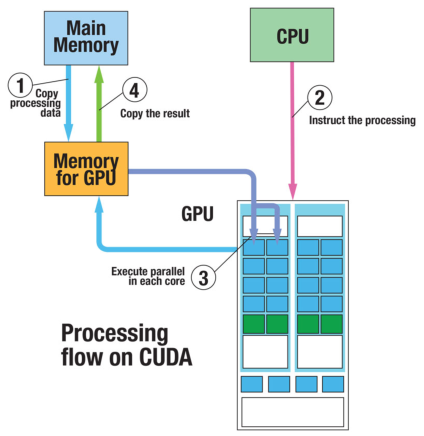



## Preparación del entorno


Esta es la copia base de solo lectura. Para empezar a trabajar sobre el notebook, **deberemos guardarnos una copia del mismo en nuestra cuenta de Google**. Es importante recordar que es recomendable utilizar la cuenta de GCloud que la Universidad de Alicante pone a disposición de los alumnos (se puede activar desde `Servicios Externos` de UACloud). Para guardarnos una copia del notebook, iremos a `Archivo > Guardar una copia en Drive` (`File > Save a copy in Drive`). Tras ello, podremos el nombre de nuestra copia.

Una vez estemos trabajando sobre nuestra copia, necesitaremos configurar el notebook para que utilice la aceleración por hardware, en concreto la GPU, ya que nuestro objetivo será ejecutar en ellas código CUDA para llevar a cabo operaciones en paralelo. Para activarla, iremos a la pestaña `Entorno de ejecución` (`Runtime`), y seleccionaremos `Cambiar tipo de entorno de ejecución` (`Change runtime type`). En el desplegable nos aseguraremos de tener seleccionado `T4 GPU` y guardaremos los cambios.

A continuación deberemos preparar el entorno que nos han reservado en Google Colab para poder ejecutar código CUDA C++ desde un notebook de este tipo. Para ello instalaremos un paquete de Python ejecutando los siguientes comandos:

## Comprobación de los recursos

Una serie de comandos nos serán útiles para ver qué hardware y qué software se nos ha asignado en el servidor remoto, que puede ser crucial a la hora de desarrollar nuestro código. En cada sesión puede cambiar, así que deberíamos comprobarlo siempre, sobre todo cuando vayamos a obtener resultados finales.

* **`nvcc`**: Compilador de CUDA instalado en nuestro sistema Linux. Podemos comprobar la versión con el parámetro `--version`.



In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


* **`nvidia-smi`**: Nos mostrará la lista de GPUs que tenemos disponibles. En estos servidores se lleva a cabo una virtualización basada en contenedores para asignar recursos, por lo que, una vez activada la opción de GPU, nos asignará una de ellas, que podremos ver listada aquí. De aquí obtendremos dos datos muy importantes: El ID de la GPU que vamos a usar (será 0 si solo tenemos una), y su nombre / modelo, con el que podremos buscar las características de la GPU, y con ello trabajar con ella en mente.

In [ ]:
!nvidia-smi

Sun Nov  5 14:36:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------



*   **`DeviceQuery`**: Es un programa incluido en el CUDA Toolkit que podemos compilar y ejecutar para obtener información relevante sobre la GPU a la hora de programar sobre ella. Más adelante veremos en qué nos resultan útiles estos datos. El `grep` que ejcutamos junto al `deviceQuery` nos sirve para flitrar los datos que más nos interesan, pero se puede quitar para ver la salida completa.



In [ ]:
#Install deviceQuery
%cd /usr/local/cuda
!git clone https://github.com/NVIDIA/cuda-samples.git
%cd /usr/local/cuda/cuda-samples/Samples/1_Utilities/deviceQuery/
!make

/usr/local/cuda-11.8
Cloning into 'cuda-samples'...
remote: Enumerating objects: 16830, done.
remote: Counting objects: 100% (2488/2488), done.
remote: Compressing objects: 100% (322/322), done.
remote: Total 16830 (delta 2211), reused 2190 (delta 2166), pack-reused 14342
Receiving objects: 100% (16830/16830), 133.20 MiB | 28.89 MiB/s, done.
Resolving deltas: 100% (14273/14273), done.
Updating files: 100% (3997/3997), done.
/usr/local/cuda-11.8/cuda-samples/Samples/1_Utilities/deviceQuery
/usr/local/cuda/bin/nvcc -ccbin g++ -I../../../Common -m64 --threads 0 --std=c++11 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_89,code=sm_89 -gencode arch=compute_90,code=sm_90 -gencode arch=compute_90,code=compute_90 -o deviceQuery.o -c de

In [ ]:
#Run deviceQuery
%cd /usr/local/cuda/cuda-samples/Samples/1_Utilities/deviceQuery/
!./deviceQuery | grep 'Device 0\|CUDA Driver Version / Runtime Version\|CUDA Capability\|Total amount of global memory\|CUDA Cores\|Maximum number of threads\|Max dimension size'

/usr/local/cuda-11.8/cuda-samples/Samples/1_Utilities/deviceQuery
Device 0: "Tesla T4"
  CUDA Driver Version / Runtime Version          12.0 / 11.8
  CUDA Capability Major/Minor version number:    7.5
  Total amount of global memory:                 15102 MBytes (15835398144 bytes)
  (040) Multiprocessors, (064) CUDA Cores/MP:    2560 CUDA Cores
  Maximum number of threads per multiprocessor:  1024
  Maximum number of threads per block:           1024
  Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
  Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)


*   **Búsqueda online de las características de nuestra GPU**: Algunas características de nuestra GPU no se mostrarán en la salida del DeviceQuery, generalmente algunas que son fijas para toda una arquitectura o para todas las GPUs que soportan las mismas `CUDA Capabilities`. En este [enlace de la Wikipedia en inglés](https://en.wikipedia.org/wiki/CUDA#Version_features_and_specifications) se recoge en unas pocas tablas la mayor parte de la información que nos puediera hacer falta.

## Instalación de librerías

Vamos a instalar las librerías necesarias para ejecutar CUDA en Numba.

In [ ]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-11.8/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-11.8/nvvm/lib64/libnvvm.so"
import numba
from numba import cuda, jit, vectorize, intp
if(numba.cuda.is_available()):
  print("CUDA available")
else:
  print("CUDA not available")
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

CUDA available


# Suma vectores

## Kernel CPU

In [ ]:
def sumaVectores_CPU(a,b,c):
   for idx in range(a.shape[0]):
      c[idx] = a[idx] + b[idx]

## Kernel GPU
1 hilo por elemento

In [ ]:
@cuda.jit
def sumaVectores(a,b,c):
    idx = cuda.grid(1)
    if idx < a.shape[0]:
        c[idx] = a[idx] + b[idx]

## Kernel GPU Strided

Cada hilo se encarga de n elementos

In [ ]:
@cuda.jit
def sumaVectores_strided(a,b,c):
    idx = cuda.grid(1)
    while idx < a.shape[0]:
        c[idx] = a[idx] + b[idx]
        idx = idx + cuda.gridDim.x

## Main

In [ ]:
# Definimos el tamaño del vector
kNumElements = 25601
print("[Vector addition of {0} elements]".format(kNumElements))

# Elegimos la GPU a utilizar, en este caso la 0
print(numba.cuda.gpus)
cuda.select_device(0)

# Reservamos memoria para los vectores en el HOST
# Inicializamos los vectores en el HOST con valores arbitrarios
h_A = np.random.rand(kNumElements)
h_B = np.random.rand(kNumElements)
h_C = np.random.rand(kNumElements)
print(h_A.shape)

# Reservamos memoria para los vectores en el DEVICE
d_A = cuda.device_array(kNumElements)
d_B = cuda.device_array(kNumElements)
d_C = cuda.device_array(kNumElements)
print(d_A.shape)

# Copiamos los vectores A y B de HOST a DEVICE
d_A = cuda.to_device(h_A)
d_B = cuda.to_device(h_B)
d_C = cuda.to_device(h_C)

[Vector addition of 25601 elements]
<Managed Device 0>
(25601,)
(25601,)


In [ ]:
# Suma Vectores básico
block = (256, 1, 1)
grid = ((kNumElements + block[0] - 1) // block[0], 1, 1)
print("Total of {0} threads launched to operate with {1} elements.".format(block[0]*grid[0], kNumElements))

%timeit sumaVectores[grid, block](d_A, d_B, d_C)

Total of 25856 threads launched to operate with 25601 elements.


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 101 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


177 µs ± 85.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Suma Vectores strided
block = (256, 1, 1)
grid = (17, 1, 1)
print("Total of {0} threads launched to operate with {1} elements.".format(block[0]*grid[0], kNumElements))

%timeit sumaVectores_strided[grid, block](d_A, d_B, d_C)

Total of 4352 threads launched to operate with 25601 elements.


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 17 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


298 µs ± 333 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
# Suma Vectores en CPU
%timeit sumaVectores_CPU(h_A, h_B, h_C)

7.53 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Copiamos el vector resultante del DEVICE al HOST
d_C.copy_to_host(h_C)
#h_C = d_C.copy_to_host() # If h_C doesn't exist

# Verificamos el resultado
for i in range(0, kNumElements):
  if abs(h_A[i] + h_B[i] - h_C[i]) > 1e-5:
    print("Error at element {0}".format(i))
    break


print("Test passed")

cuda.close()

Test passed


# Ejercicios

##Fractal Mandelbrot
En esta práctica se van a crear fractales de Mandelbrot utilizando un kernel en GPU. Podemos hacer esto gracias a que es un proceso paralelizable, ya que el cálculo del color de cada píxel depende exclusivamente de la posición del mismo. Para hecho trataremos cada pixel como un número complejo. Mapeando la posición (x,y) a (i,j).


###1.  Programa el kernel en GPU para que calcule el color correspondiente del fractal dado un pixel.
Puedes probar con diferentes fórmulas de definición de fractales. Las podéis encontrar resumidas [aquí](https://es.wikipedia.org/wiki/Desarrollo_de_fractales_mediante_el_m%C3%A9todo_de_Mandelbrot#Z_=_Zm_+_C).

###2.   Copiar el código anterior en el kernel para CPU y comparar los tiempos de cálculos con los kernel de CPU y GPU

Haz pruebas utilizando los mismos parámetros para graficar el mismo fractal con GPU y CPU. Rellena la siguiente tabla con el tiempo requerido en cada caso.

| Ejecución |     Parámetros   | Tiempo GPU | Tiempo CPU |
|-----------|------------------|------------|------------|
| Ejemplo   |  $Z = Z^2 +C$    | 1.34s      | 8.69s      |
| 1         |  $Z = Z^6 +C$    | 3.68s      | 85.70      |
| 2         | $Z = Z^10 +C$    | 3.72s      | 90.80s     |




---
## Integración por Montecarlo

Vamos a utilizar la programación en paralelo en GPU con CUDA para llevar a cabo una estimación numérica de integrales mediante el método de Montecarlo. Como sabéis, el método de Montecarlo es una técnica probabilística que se utiliza para aproximar el valor de una integral definida, especialmente cuando la función a integrar es compleja o no tiene una expresión analítica fácil.

En cada ejecución del kernel se calculará el valor de f con valores aleatorios de x dentro del intervalo establecido, y devolviendo una aproximación de la integral. Finalmente, se hará la media de los resultados de todas las ejecuciones de todos los hilos para obtener un resultado final preciso.

###3.   Código para calcular f
Se proporciona una función f(x) que representa la función que queremos integrar. Completa el código dentro de la función para que devuelva el valor de la función f(x) para un valor dado de x. Debes utilizar el decorador correcto para permitir que esta función se ejecute en la GPU.

###4.  Utiliza el acumulador ac para calcular el valor de f en para valores aleatorios de x en el intervalo [a,b]
En este ejercicio, se utiliza una variable `ac` como acumulador. El objetivo es calcular el valor de f(x) para valores aleatorios de x en el intervalo [a, b] y usar el acumulador para acumular estos valores en cada hilo del kernel. Debes completar el código dentro del bucle para calcular adecuadamente el valor de f(x) y acumularlo en ac. El kernel debe devolver una aproximación de la integral teniendo en cuenta los valores de y acumulados.


###5.  Ahora prueba a definir esta otra función y comprueba que da el resultado correcto al lanzarla en el kernel

Define otra función f(x) similar a la anterior. Luego, debes usar el decorador adecuado para permitir que esta función se ejecute en la GPU.

Comprueba la precisión del método varíando los parámetros: número de muestras que toma cada kernel (n) y número de hilos (nthreads). Rellena la tabla calculando $f(x) = e^{-x^{2}}$:



|     n     |  nthreads |Resultado integral| Tiempo GPU |
|-----------|-----------|------------|------------|
| 1000 |  1000    | 0.8909258     |  0.266383 |
| 10000 |  1000    |  0.8869347   |  0.014065   |
| 1000000|  1000     |  0.8863658  |  0.666881    |
| 1000000 |  2000     |  0.8864502  |   0.837466   |
| 1000000 |  5000     |  0.8864091   |  1.413725    |

Valor aproximado por calculadora de integrales: 0.886226925452758

Datos de $f(x) = e^{-x^{2}}$


> ### Explica los tiempos obtenidos con 1000,2000 y 5000 hilos.
>Spoiler: El incremento no es constante, lineal ni exponencial. A que se deben estos valores?
>
>     Es cierto que el tiempo de ejecución no sigue ninguna progresion constante al incrementar el numero de hilos. Esto puede deberse a diferentes factores que influyen en la resolución del problema, como pueden ser la arquitectura y/o la capacidad de la GPU o como Numba gestiona los diferentes hilos.
>     En el caso de la practica tenemos disponibles 2560 CUDA Cores, por lo que solo se podrán ejecutar 2560 hilos simultaneamente, es por eso por lo que tenemos un tiempo de ejecución mas elevado al ejecuat 5000 hilos.
>

# Mandelbrot fractal

In [ ]:
#Importación de librerías
from __future__ import print_function, division, absolute_import
from timeit import default_timer as timer
from matplotlib.pylab import imshow, show
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit

#Parámetros del fractal
width = 10000
height = 8000

Para crear imágenes de fractales Mandelbrot vamos a crear un kernel que calcule el color de un pixel dado un número complejo (posición x, y de la imágen)
El kernel debe devolver un **número entero** que se tratará como un color utilizando una [paleta de colores](https://matplotlib.org/stable/tutorials/colors/colormaps.html) de matplotlib. Por defecto se utilizará la paleta `rainbow`.

## Kernel GPU

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Execution time: 3.720290 seconds


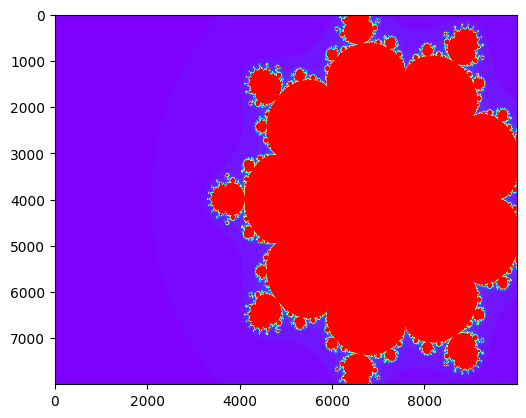

In [ ]:
# E1: Programar el kernel para que calcule el color correspondiente del fractal dado un pixel
@cuda.jit(device=True)
def mandel(x, y, max_iters):
    """
    Dado un número complejo, determinar si es candidato a pertenecer al
    conjunto de Mandelbrot dado un número fijo de iteraciones.
    """
    i = 0
    c = complex(x, y)
    z = 0.0j
    """
    for i in range(max_iters):
        z = z**6 + c

        if (z.real**2 + z.imag**2) >= 2:
            return i * 3

    return 200
    """
    for i in range(max_iters):
        z = z**10 + c

        if (z.real**2 + z.imag**2) >= 2:
            return i * 3

    return 200


@cuda.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    x, y = cuda.grid(2)

    if x < width and y < height:
        real = min_x + x * pixel_size_x
        imag = min_y + y * pixel_size_y
        color = mandel(real, imag, iters)
        image[y, x] = color


image = np.zeros((height, width), dtype=np.uint8)

pixels = width * height
nthreads = 32
nblocksy = (height // nthreads) + 1
nblocksx = (width // nthreads) + 1
s = timer()

create_fractal[(nblocksx, nblocksy), (nthreads, nthreads)](
    -2.0, 0.8, -1, 1, image, 50
)

e = timer()
print("Execution time: %f seconds" % (e - s))

plt.imshow(image, cmap = "rainbow")
plt.savefig('mandelGPU.png')


## Kernel CPU

Execution time: 90.803530 seconds


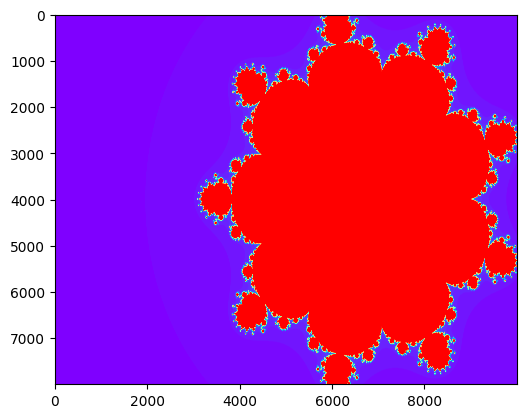

In [ ]:
#E2. Copiar el código anterior en el kernel para CPU y comparar los tiempos de cálculos con los kernel de CPU y GPU
@jit
def mandel(x, y, max_iters):
    """
    Dado un número complejo, determinar si es candidato a pertenecer al
    conjunto de Mandelbrot dado un número fijo de iteraciones.
    """
    i = 0
    c = complex(x, y)
    z = 0.0j #Si no especifico el tipo de variable me aparece error.

    """
    for i in range(max_iters):
        z = z**6 + c

        if (z.real**2 + z.imag**2) >= 2:
            return i * 3

    return 200
    """
    for i in range(max_iters):
        z = z**10 + c

        if (z.real**2 + z.imag**2) >= 2:
            return i * 3

    return 200

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image


image = np.zeros((height, width), dtype=np.uint8)

s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print("Execution time: %f seconds" % (e - s))

plt.imshow(image, cmap = "rainbow")
plt.savefig('mandelCPU.png')

# Integración por Montecarlo

$f(x) = \frac{sin(x)}{x} $

In [ ]:
#E3. Escribe el código necesario dentro de f para devolver el resultado de la función anterior

#Insertar aquí el decorador correcto para poder ejecutar esta función dentro de GPU
import math

@cuda.jit(device=True)
def f(x):
    return math.sin(x) / x


$f(x) = e^{-x^{2}}$

In [ ]:
#E5. Ahora prueba a definir esta otra función y comprueba que da el resultado correcto al lanzarla en el kernel

#Insertar aquí el decorador correcto para poder ejecutar esta función dentro de GPU

@cuda.jit(device=True)
def f(x):
    return math.exp(-x**2)


In [ ]:
import numpy as np
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import math
from timeit import default_timer as timer

@cuda.jit
def monte_carlo_integration_kernel(d_result, d_rng_states, n, a, b):
    tid = cuda.grid(1)

    # Initialize the random number generator for this thread
    rng_state = d_rng_states[tid]

    ac = 0.0

    for i in range(n):
        # Generate a random number in the range [a, b]
        rand_num = xoroshiro128p_uniform_float32(d_rng_states,tid)

        #Creación de un numero aleatorio, calculo de la funcion y suma al acumulador
        x = a + rand_num * (b - a)
        resultado = f(x)
        ac += resultado

    # Guardamos el valor de la integral obtenido en este hilo
    d_result[tid] = ac * (b - a) / n

In [ ]:
# Set the integration interval and number of random samples
a = 0
b = 100

#Parámetros lanzamiento kernel
n = 1000000
nthreads = 5000

threads_per_block = 32
blocks =  (nthreads + threads_per_block - 1) // threads_per_block

# Allocate memory on the device
d_result = cuda.device_array(threads_per_block * blocks, dtype=np.float32)
d_rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)

s = timer()
# Launch the kernel
monte_carlo_integration_kernel[blocks, threads_per_block](d_result, d_rng_states, n, a, b)

# Copy the result back to the host
result = d_result.copy_to_host().mean()
e = timer()
print("Execution time: %f seconds" % (e - s))
print("Result:", result)

Execution time: 1.413725 seconds
Result: 0.8864091
